User Engagement analysis


In [25]:
import pandas as pd
from dbconnection import create_database_connection, read_data_into_dataframe


In [26]:
engine = create_database_connection()
df=read_data_into_dataframe(engine, "xdr_data")


In [27]:
#data preparation
numeric_data= df.loc[:, df.dtypes != 'object']
non_numeric_columns = df.select_dtypes(exclude=['number']).columns
cleaned_data = numeric_data.fillna(numeric_data.mean())



In [28]:
#Track the user’s engagement using the following engagement metrics
session_frequency = df['MSISDN/Number'].value_counts()
session_frequency = session_frequency .reset_index()
session_frequency.columns = ['MSISDN/Number', 'session_frequency']
session_frequency.head(10)

,MSISDN/Number,session_frequency
0,3.362632e+10,18
1,3.361489e+10,17
2,3.362578e+10,17
3,3.365973e+10,16
4,3.376054e+10,15
5,3.367588e+10,15
6,3.366716e+10,13
7,3.360313e+10,12
8,3.378632e+10,12
9,3.362708e+10,12


In [29]:
# sessions  session duration

df['start_time'] = pd.to_datetime(df['Start'])
df['end_time'] = pd.to_datetime(df['End'])
df['duration'] = df['end_time'] - df['start_time']

# Group by customer_id and sum the session durations
total_session_duration = df.groupby('MSISDN/Number')['duration'].sum().reset_index().sort_values(by='duration', ascending=False)
total_session_duration

,MSISDN/Number,duration
13180,3.362578e+10,214 days 17:49:00
6437,3.361489e+10,115 days 08:40:00
92923,3.376054e+10,107 days 09:41:00
13526,3.362632e+10,101 days 18:18:00
65118,3.366716e+10,101 days 05:03:00
...,...,...
24741,3.365043e+10,0 days 02:01:00
85146,3.369839e+10,0 days 02:01:00
35287,3.365933e+10,0 days 02:00:00
60767,3.366566e+10,0 days 01:59:00


In [30]:
# total data usage (DL and UL)

df['Total Data Usage'] = df['Total UL (Bytes)'] + df['Total DL (Bytes)']

# Group by customer_id and sum the session durations
total_data_usage = df.groupby('MSISDN/Number')['Total Data Usage'].sum().reset_index().sort_values(by='Total Data Usage', ascending=False)
total_data_usage

,MSISDN/Number,Total Data Usage
6437,3.361489e+10,8.846226e+09
92923,3.376054e+10,8.514774e+09
13180,3.362578e+10,8.499621e+09
13526,3.362632e+10,7.971167e+09
76363,3.367588e+10,7.891111e+09
...,...,...
76161,3.367548e+10,3.802236e+07
104769,3.378251e+10,3.792924e+07
63657,3.366668e+10,3.399962e+07
43677,3.366132e+10,3.357584e+07


Aggregate the above metrics per customer id (MSISDN)

In [48]:
import pandas as pd
#Merging the 3 stated engagement metrics in one data frame

merged_df = pd.merge(session_frequency, total_session_duration,  on='MSISDN/Number',how="outer")

# Merge the result with total_data_usage on 'MSISDN/Number'
merged_df = pd.merge(merged_df, total_data_usage, on='MSISDN/Number')

merged_df.head()


,MSISDN/Number,session_frequency,duration,Total Data Usage
0,3.362632e+10,18,101 days 18:18:00,7.971167e+09
1,3.361489e+10,17,115 days 08:40:00,8.846226e+09
2,3.362578e+10,17,214 days 17:49:00,8.499621e+09
3,3.365973e+10,16,46 days 16:54:00,7.705863e+09
4,3.376054e+10,15,107 days 09:41:00,8.514774e+09


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans


# Select the engagement metrics for clustering


merged_df['duration'] = merged_df['duration'].dt.total_seconds()
engagement_metrics = merged_df[['session_frequency', 'duration', 'Total Data Usage']]

# Normalize the engagement metrics using MinMax Scaler
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics)

# Run k-means clustering with k=3
km = KMeans(n_clusters=3)
merged_df['Cluster'] = km.fit_predict(normalized_metrics)

# Display the DataFrame with the cluster assignments
print(merged_df)


c:\Users\hp\.conda\envs\your_env_name\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


        MSISDN/Number  session_frequency    duration  Total Data Usage  \
0        3.362632e+10                 18   8792280.0      7.971167e+09   
1        3.361489e+10                 17   9967200.0      8.846226e+09   
2        3.362578e+10                 17  18553740.0      8.499621e+09   
3        3.365973e+10                 16   4035240.0      7.705863e+09   
4        3.376054e+10                 15   9279660.0      8.514774e+09   
...               ...                ...         ...               ...   
106851   3.366068e+10                  1     56880.0      6.463499e+08   
106852   3.364517e+10                  1     97560.0      6.347028e+08   
106853   3.365821e+10                  1     93180.0      1.975654e+08   
106854   3.366338e+10                  1     95580.0      7.343901e+08   
106855   3.361962e+10                  1     97920.0      4.015220e+08   

        Cluster  
0             2  
1             2  
2             2  
3             2  
4             2  
...

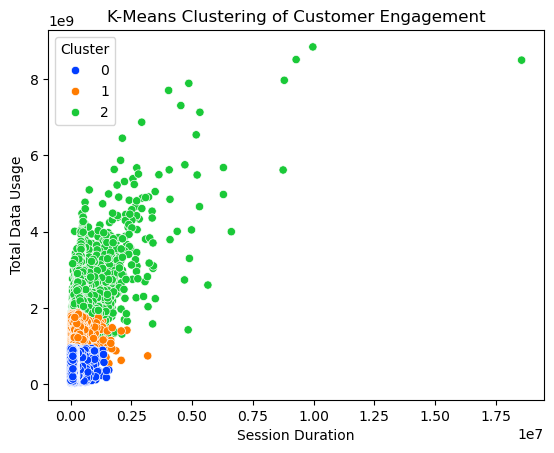

In [50]:
# Plot the clusters
sns.scatterplot(x='duration', y='Total Data Usage', hue='Cluster', data=merged_df, palette='bright' )
plt.title('K-Means Clustering of Customer Engagement')
plt.xlabel('Session Duration')
plt.ylabel('Total Data Usage')
plt.show()

What is the optimized value of k

In [51]:
#Using elbow method
k_range=range(1,10)
sum_square_error=[]
for k in k_range:
    km=KMeans(n_clusters=k)
    km.fit_predict(normalized_metrics)
    sum_square_error.append(km.inertia_)

c:\Users\hp\.conda\envs\your_env_name\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hp\.conda\envs\your_env_name\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hp\.conda\envs\your_env_name\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hp\.conda\envs\your_env_name\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

In [52]:
sum_square_error

[582.7488332296591,
 260.6051460879765,
 159.98865105447675,
 115.49717733116987,
 88.62857586728146,
 70.32790803020707,
 57.80828149888516,
 49.49410778111433,
 43.16567965546042]

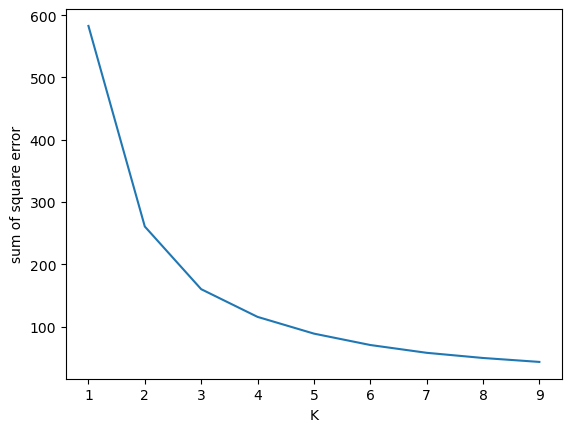

In [53]:
plt.xlabel('K')
plt.ylabel('sum of square error')
plt.plot(k_range,sum_square_error)
